# Forest Cover Prediction Using pyspark

## Introduction:
**Analysis Flow:**  
  - **Part A: Set up the Environment**  
  - **Part B: Load and Explore the Data**
  - **Part C: Preprocessing and Splitting the Data**
  - **Part D: Hyperparameter Tuning for Logistic Regression**
  - **Part E: Hyperparameter Tuning for Decision Trees**  
  - **Part F: Identifying and Evaluating the Final Model**  
  - **Part G: Applying the Model to New Data:**

## Part A: Set up the Environment
We will start by importing the required pyspark tools.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

spark = SparkSession.builder.getOrCreate()

## Part B: Load and Explore the Data
In this part, we will load and preview the forest_cover data.

We will start by creating the schema and reading the data.

In [ ]:
fc_schema = (
'Elevation INTEGER,  Aspect INTEGER, Slope INTEGER, Horizontal_Distance_To_Hydrology INTEGER,' 'Vertical_Distance_To_Hydrology INTEGER, Horizontal_Distance_To_Roadways INTEGER, Hillshade_9am INTEGER,'
'Hillshade_Noon INTEGER, Hillshade_3pm INTEGER, Horizontal_Distance_To_Fire_Points INTEGER,'
 'Wilderness_Area STRING, Soil_Type INTEGER, Cover_Type INTEGER'
)
fc = (
  spark.read
       .option('delimiter', '\t')
       .option('header', True)
       .schema(fc_schema)
       .csv('/FileStore/tables/forest_cover.csv')
          )
fc.printSchema()

root
-- Elevation: integer (nullable = true)
-- Aspect: integer (nullable = true)
-- Slope: integer (nullable = true)
-- Horizontal_Distance_To_Hydrology: integer (nullable = true)
-- Vertical_Distance_To_Hydrology: integer (nullable = true)
-- Horizontal_Distance_To_Roadways: integer (nullable = true)
-- Hillshade_9am: integer (nullable = true)
-- Hillshade_Noon: integer (nullable = true)
-- Hillshade_3pm: integer (nullable = true)
-- Horizontal_Distance_To_Fire_Points: integer (nullable = true)
-- Wilderness_Area: string (nullable = true)
-- Soil_Type: integer (nullable = true)
-- Cover_Type: integer (nullable = true)

We will now display the first three rows of each of the columns to have a quick view of the data.

In [ ]:
fc.select(fc.columns).toPandas().head(3)

Out[16]:

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,Rawah,29,5
1,2590,56,2,212,-6,390,220,235,151,6225,Rawah,29,5
2,2804,139,9,268,65,3180,234,238,135,6121,Rawah,12,2


Here, we will count and print the numbers of observations (rows) in the DataFrame and store it in a variable for future calculation.

In [ ]:
N = fc.count()
print(N)

15120

Now, we will further explore the data by calculating and displaying the proportion of each of the Cover_Type in the data.

In [ ]:
(
fc.groupBy('Cover_Type')
  .agg(
    expr('COUNT(*) as count'),
    expr(f'ROUND(COUNT(*)/{N},4) as prop'))
  .select('Cover_Type','prop')
  .toPandas()
  )

Out[18]:

,Cover_Type,prop
0,1,0.1429
1,6,0.1429
2,3,0.1429
3,5,0.1429
4,4,0.1429
5,7,0.1429
6,2,0.1429


## Part C: Preprocessing and Splitting the Data
In this part, we will create stages to convert the feature and label variables to appropriate type for analysis. We will then create a preprocessing pipeline to be used for future transformation of similar DataFrame.

We will start by creating the list of categorical and numerical features and encode/assemble them with StringIndexer, OneHotEncoder, VectorAssembler as needed.   
Logistic regression model needs the feature indexing as well as oneHotEncoding of categorical variables while decision tree performs better with feature indexing without oneHotEncoding.

In [ ]:
#'Wilderness_Area', 'Soil_Type' are the only categorical variables, rest are the numerical variables in the DataFrame.
# Cover_Type is label and is already a numerical variable in this DataFrame

cat_features = ['Wilderness_Area', 'Soil_Type']         # Categorical features
num_features = [c for c in fc.columns[:-1] if c not in cat_features]    # Numerical features

ix_features = [c + '_ix' for c in cat_features]   # create new variables with -ix suffix for feature indexing
vec_features = [c + '_vec' for c in cat_features] # create new variables with -vec suffix for oneHot encoding

feature_indexer = StringIndexer(inputCols = cat_features, outputCols = ix_features)
encoder = OneHotEncoder(inputCols = ix_features, outputCols = vec_features, dropLast = False)

assembler_lr = VectorAssembler(inputCols = num_features + vec_features, outputCol = 'features_lr')
# takes the numerical and oneHot encoded categorical feature variables as input and transformed to output feature named 'features_lr' for logistic regression model.

assembler_dt = VectorAssembler(inputCols = num_features + ix_features, outputCol = 'features_dt')
# takes the numerical and indexed feature variables as input and transformed to output feature named 'features_dt' for decision tree model. Decision tree model does not need the categorical featrues to be oneHot encoded.


We will now create a pipeline from preprocessing stages created above which is then applied to the data for appropriate data transformation.

In [ ]:
pre_pipe = Pipeline(stages=[feature_indexer, encoder, assembler_lr, assembler_dt]).fit(fc)
# data transformed above can be used for both logistic regression and decision tree model as it has feature transformation appropriate for both model.

fc_proc = pre_pipe.transform(fc)
fc_proc.persist() # persist the ouput for future quick access.
fc_proc.select(['features_dt', 'Cover_Type']).toPandas().head(5)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features_dt. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[20]:

,features_dt,Cover_Type
0,"[2596.0, 51.0, 3.0, 258.0, 0.0, 510.0, 221.0, ...",5
1,"[2590.0, 56.0, 2.0, 212.0, -6.0, 390.0, 220.0,...",5
2,"[2804.0, 139.0, 9.0, 268.0, 65.0, 3180.0, 234....",2
3,"[2785.0, 155.0, 18.0, 242.0, 118.0, 3090.0, 23...",2
4,"[2595.0, 45.0, 2.0, 153.0, -1.0, 391.0, 220.0,...",5


We will now randomly split the data into 80:20 as Train and Test data to train our model and then later test the model using out of sample (test) data. We will confirm the split by counting the number of rows in each DataFrame.

In [ ]:
splits = fc_proc.randomSplit([0.8, 0.2], seed=1)
train = splits[0]
test = splits[1]

train.persist()

print(f'Training Observations: {train.count()}')
print(f'Testing Observations:  {test.count()}')

Training Observations: 12118
Testing Observations: 3002

## Part D: Hyperparameter Tuning for Logistic Regression
In this part, we will perform the hyperparameter tuning using accuracy as model performance evaluator and evaluate the logistic regression models thus created.

We will start by creating an instance of MulticlassClassificationEvaluator to calculate the accuracy metric.

In [ ]:
accuracy_eval = MulticlassClassificationEvaluator(
                            predictionCol = 'prediction',
                            labelCol = 'Cover_Type',
                            metricName = 'accuracy')

Now, we will create a LogisticRegression instance, create a grid search parameters and then cross validate the models within the below arbitrary search parameters.  
  - regParam: 0.00001, 0.0001, 0.001, 0.01, 0.1  
  - elasticNetParam: 0, 0.5, 1

In [ ]:
logreg = LogisticRegression(featuresCol='features_lr', labelCol='Cover_Type')

param_grid = (ParamGridBuilder()
              .addGrid(logreg.regParam, [0.00001, 0.0001, 0.001, 0.01, 0.1])
              .addGrid(logreg.elasticNetParam, [0, 0.5, 1])
             ).build()

cv = CrossValidator(estimator=logreg,
                    estimatorParamMaps=param_grid,
                    evaluator=accuracy_eval,
                    numFolds=5,
                    seed=1,
                    parallelism=8)

cv_model = cv.fit(train)

/databricks/spark/python/pyspark/ml/util.py:838: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

Now, we will identify the optimal model under the grid search parameters above and calculate the CV Score, Lambda and Alpha of the optimal model.

In [ ]:
lr_model = cv_model.bestModel
opt_regParam = lr_model.getRegParam()
opt_enetParam = lr_model.getElasticNetParam()

print('Max CV Score: ', round(max(cv_model.avgMetrics),4))
print('Optimal Lambda: ', opt_regParam)
print('Optimal Alpha: ', opt_enetParam)

Max CV Score: 0.6741
Optimal Lambda: 1e-05
Optimal Alpha: 0.0

Here, we will show the CV Scores vs regularization parameters within the gridsearch parameters using the line plots to display how they change and also to visually display the optimal model parameters.

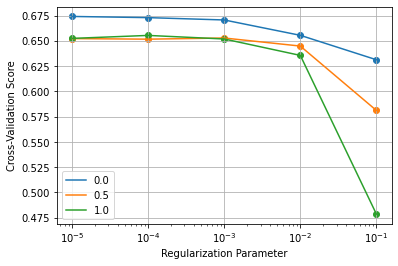

In [ ]:
model_params = cv_model.getEstimatorParamMaps()

lr_cv_summary_list = []

for param_set, acc in zip(model_params, cv_model.avgMetrics):
  new_set = list(param_set.values()) + [acc]
  lr_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(lr_cv_summary_list, columns=['reg_param', 'enet_param', 'acc'])

for en in cv_summary.enet_param.unique():
  sel = cv_summary.enet_param == en
  plt.plot(cv_summary.reg_param[sel], cv_summary.acc[sel], label=en)
  plt.scatter(cv_summary.reg_param[sel], cv_summary.acc[sel])

plt.legend()
plt.xscale('log')
plt.grid()
plt.xlabel('Regularization Parameter')
plt.ylabel('Cross-Validation Score')
plt.show()

##Part E: Hyperparameter Tuning for Decision Trees
In this part, we will perform the hyperparameter tuning using accuracy as model performance evaluator and evaluate the Decision Tree models thus created.

We will start by creating a DecisionTreeClassifier instance, create a grid search parameters and then cross validate the models within the arbitrary search parameters below.  
  - maxDepth: 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24  
  - minInstancesPerNode: 1, 2, 4

In [ ]:
dtree = DecisionTreeClassifier(featuresCol='features_dt', labelCol='Cover_Type', seed=1, maxBins = 38)

param_grid = (ParamGridBuilder()
              .addGrid(dtree.maxDepth, [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24])
              .addGrid(dtree.minInstancesPerNode, [1, 2, 4])
             ).build()

cv = CrossValidator(estimator=dtree,
                    estimatorParamMaps=param_grid,
                    numFolds=5,
                    evaluator=accuracy_eval,
                    seed=1,
                    parallelism=6)

cv_model = cv.fit(train)


/databricks/spark/python/pyspark/ml/util.py:838: UserWarning: Cannot find mlflow module. To enable MLflow logging, install mlflow from PyPI.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

Now, we will identify the optimal model under the grid search parameters above and calculate the CV Score, Lambda and Alpha of the optimal model.

In [ ]:
dt_model = cv_model.bestModel
opt_maxDepth = dt_model.getMaxDepth()
opt_minInstancesPerNode = dt_model.getMinInstancesPerNode()

print('Max CV Score:   ', round(max(cv_model.avgMetrics),4))
print('Optimal Depth:  ', opt_maxDepth)
print('Optimal MinInst:', opt_minInstancesPerNode)

Max CV Score: 0.7775
Optimal Depth: 16
Optimal MinInst: 1

Here, we will show the CV Scores vs regularization parameters within the gridsearch parameters using line plots to display how they change and also to visually display the optimal model parameters.

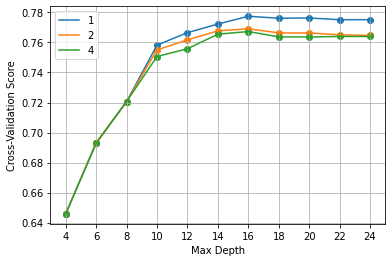

In [ ]:
model_params = cv_model.getEstimatorParamMaps()

dt_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
  new_set = list(param_set.values()) + [acc]
  dt_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(dt_cv_summary_list, columns=['maxDepth', 'minInst', 'acc'])

for mi in cv_summary.minInst.unique():
  sel = cv_summary.minInst == mi
  plt.plot(cv_summary.maxDepth[sel], cv_summary.acc[sel], label=mi)
  plt.scatter(cv_summary.maxDepth[sel], cv_summary.acc[sel])

plt.legend()
plt.grid()
plt.xticks(range(4,26,2))
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation Score')
plt.show()

Now, we will calculate and display each of the features and their importance as evaluated by optimal decision tree model.

In [ ]:
features_dt = num_features + cat_features

pd.DataFrame({
    'feature':features_dt,
    'importance':dt_model.featureImportances
         })

Out[29]:

,feature,importance
0,Elevation,0.394260
1,Aspect,0.048116
2,Slope,0.026453
3,Horizontal_Distance_To_Hydrology,0.078278
4,Vertical_Distance_To_Hydrology,0.036748
5,Horizontal_Distance_To_Roadways,0.070875
6,Hillshade_9am,0.025840
7,Hillshade_Noon,0.023199
8,Hillshade_3pm,0.017314
9,Horizontal_Distance_To_Fire_Points,0.079365


## Part F: Identifying and Evaluating the Final Model
In this part, we will compare the optimal logistic regression and optimal decision tree model to identify the best model between them. We will then evaluate the best model's performance with out of sample (test) data.

The optimal logistic regression model (lr_model) has cross validation score (5 fold) of 0.6739 while the same for optimal decision tree model (dt_model) is 0.7775 using the train data. This means that ,based on the cross validation score, optimal decision tree model (dt_model) predicted correctly about 77.8% of time while optimal logistic regression model predicted correctly only about 63.4% of time with the train data.  
As decision tree model performed better than logistic regression model, we will use decision tree model for future prediction.

Let's use the optimal decision tree model as determined above to predict the label of test data and show the first 10 rows of probability, prediction, and actual label value (Cover_Type).

In [ ]:
test_pred = dt_model.transform(test)
test_pred.select('probability', 'prediction', 'Cover_Type').toPandas().head(10)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field probability. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
Out[30]:

,probability,prediction,Cover_Type
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",6.0,6
1,"[0.0, 0.0, 0.0273972602739726, 0.3150684931506...",6.0,6
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",6.0,6
3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3.0,3
4,"[0.0, 0.0, 0.0, 0.09375, 0.0, 0.0, 0.90625, 0.0]",6.0,6
5,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3.0,3
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3.0,6
7,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3.0,3
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",6.0,3
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",6.0,6


Now, we will calculate the accuracy of the optimal model selected above using out of sample (test) data.     
As calculated below, the accuracy value seems to be close to what it was with train data.

In [ ]:
pred_and_labels = test_pred.rdd.map(lambda x:(x['prediction'],float(x['Cover_Type'])))
metrics = MulticlassMetrics(pred_and_labels)
print(f'Test Set Accuracy: {round(metrics.accuracy,4)}')

Test Set Accuracy: 0.7818

Now, let's build and display the confusion matrix.

In [ ]:
labels = Cover_Type = ['1','2', '3', '4', '5', '6', '7']

cm = metrics.confusionMatrix().toArray().astype(int)
pd.DataFrame(
    data=cm,
    columns= Cover_Type,
    index= Cover_Type
      )

Out[32]:

,1,2,3,4,5,6,7
1,311,90,2,0,13,5,36
2,101,220,12,0,58,11,3
3,1,10,306,23,13,78,0
4,0,1,22,423,0,25,0
5,9,26,3,0,364,4,0
6,1,4,58,13,5,319,0
7,19,7,0,0,2,0,404


As shown above, observations in the test set with Cover Type 2 were misclassified by the model as Cover Type 1 a total of 101 times. This was the most common type of misclassification in the test set.

Now, we will display the precision and recall values of the model for each Cover Type.

In [ ]:
print('Label   Precision   Recall')
print('--------------------------')
for lab in (Cover_Type):
  print(f'{lab:<8}{metrics.precision(lab):<12.4f}{metrics.recall(lab):.4f}')

Label Precision Recall
--------------------------
1 0.7036 0.6805
2 0.6145 0.5432
3 0.7593 0.7100
4 0.9216 0.8981
5 0.8000 0.8966
6 0.7217 0.7975
7 0.9120 0.9352

**Some observations based on precision and recall value of the final model:**
- As label 7 (Cover Type 7) has the highest recall value (0.9352), this label type is most likely to be correctly classified by our final model. <br \>
- Label type 2 (Cover Type 2) has the lowest recall score (0.5432). This means that the probability of identifying a cover type as type 2 out of all type 2 cover type is only about 54.32% and hence is most likely to be misclassified by the final model.<br \>
- Label type 5 (Cover Type 5) has the highest difference in precision and recall values (difference: 0.0966). There is about 80% probalility that the model correctly identifies Cover Type 5 while there is about 89.7% probability that the model correctly identifies a cover type as Cover Type 5 out of all existing Cover Type 5.